# Sheet 2: Maximum Likelihood Estimation

In this exercise sheet, we will look at various properties of maximum-likelihood estimation, and how to find maximum-likelihood parameters.

### ML vs. James Stein Estimator (15 P)

Let $X_1,\dots,X_n \in \mathbb{R}^d$ be independent draws from a multivariate Gaussian distribution with mean vector $\mu$ and covariance matrix $\Sigma = \sigma^2 I$. It can be shown that the maximum-likelihood estimator of the mean parameter $\mu$ is the empirical mean given by:
$$
\hat \mu_\text{ML} = \frac1N \sum_{i=1}^N X_i
$$
It was once believed that the maximum-likelihood estimator was the most accurate possible (i.e. the one with the smallest Euclidean distance from the true mean). However, it was later demonstrated that the following estimator
$$
\hat \mu_{JS} = \Big(1-\frac{(d-2) \cdot \sigma^2}{n \cdot \|\mu_\text{ML}\|^2}\Big) \hat \mu_\text{ML}
$$
(a shrinked version of the maximum-likelihood estimator towards the origin) has actually a smaller distance from the true mean when $d \geq 3$. This however assumes knowledge of the variance of the distribution for which the mean is estimated. This estimator is called the James-Stein estimator. While the proof is a bit involved, this fact can be easily demonstrated empirically through simulation. This is the object of this exercise.

The code below draws ten 50-dimensional points from a normal distribution with mean vector $\mu = (1,\dots,1)$ and covariance $\Sigma = I$.

In [3]:
import numpy 
def getdata(seed):

    n = 10              # data points
    d = 50              # dimensionality of data
    m = numpy.ones([d]) # true mean
    s = 1.0             # true standard deviation

    rstate = numpy.random.mtrand.RandomState(seed)
    X = rstate.normal(0,1,[n,d])*s+m
    
    return X,m,s

The following function computes the maximum likelihood estimator from a sample of the data assumed to be generated by a Gaussian distribution:

In [4]:
def ML(X):
    return X.mean(axis=0)

* **Based on the ML estimator function, write a function that receives as input the data $(X_i)_{i=1}^n$ and the (known) variance $\sigma^2$ of the generating distribution, and computes the James-Stein estimator**

In [5]:
def JS(X,s):
    n = X.shape[0]
    d = X.shape[1]
    mu_ML = ML(X)
    sum_of_squares = numpy.sum(mu_ML**2)
    m_JS = 1 - ((d - 2) * s**2)/(n * sum_of_squares)
    m_JS *= mu_ML
    return m_JS

We would like to compute the error of the maximum likelihood estimator and the James-Stein estimator for 100 different samples (where each sample consists of 10 draws generated by the function `getdata` with a different random seed). Here, for reproducibility, we use seeds from 0 to 99. The error should be measured as the Euclidean distance between the true mean vector and the estimated mean vector.

* **Compute the maximum-likelihood and James-Stein estimations.**
* **Measure the error of these estimations.**
* **Build a scatter plot comparing these errors for different samples.**

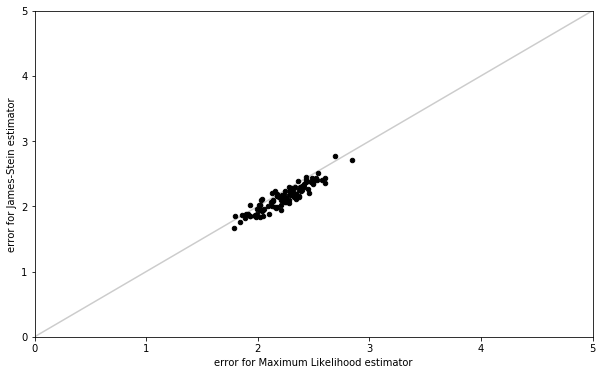

In [6]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

m_JS_list = []
m_ML_list = []
m = None
for i in range(100):
    X,m,s = getdata(i)
    m_ML_list.append(ML(X))
    m_JS_list.append(JS(X,s))

m_JS = numpy.array(m_JS_list)
m_JS -= m
m_JS = m_JS**2
m_JS = numpy.sqrt(numpy.sum(m_JS,axis=1))

m_ML = numpy.array(m_ML_list)
m_ML -= m
m_ML = m_ML**2
m_ML = numpy.sqrt(numpy.sum(m_ML,axis=1))


fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.set_xlabel("error for Maximum Likelihood estimator")
ax.set_ylabel("error for James-Stein estimator")
ax.set_xlim([0,5])
ax.set_ylim([0,5])
ax.scatter(m_ML,m_JS,s=20,alpha=1,c='k')
ax.plot([0,5],[0,5],alpha=0.2,c='k')
###

### Parameters of a mixture of exponentials (15 P)

We consider the following "mixture of exponentials" distribution supported on $\mathbb{R}^+$, that we use to generate data, but whose parameters $\alpha$ and $\beta$ are unknown.

$$p(x;\alpha,\beta) = 0.5 \cdot \big[\alpha e^{-\alpha x} + \beta e^{-\beta x}\big]$$

A dataset $\mathcal{D} = x_1,\dots,x_N$ with $N=200$ has been generated from that distribution. It is given below and plotted as a histogram.

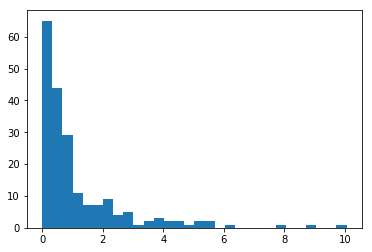

In [7]:
D=[ 0.74,  0.20,  0.56,  0.05,  0.67,  0.41,  0.74,  4.63,  0.59,  0.39,
    0.71,  0.17,  5.34,  0.33,  0.01,  1.11,  0.60,  0.41,  0.65,  1.97,
    0.19,  0.80,  0.04,  0.48,  0.54,  0.59,  0.31,  1.40,  0.63,  0.38,
    0.36,  0.02,  0.68,  0.72,  0.84,  0.30,  0.01,  1.37,  0.89,  0.10,
    0.21,  0.68,  0.14,  0.10,  0.11,  0.01,  0.09,  0.50,  0.34,  0.30,
    1.22, 10.05,  0.19,  0.04,  0.13,  1.53,  2.28,  1.76,  0.03,  0.31,
    0.37,  0.50,  0.05,  0.30,  0.53,  0.63,  4.20,  0.86,  0.29,  1.98,
    1.27,  0.35,  0.43,  0.35,  0.75,  0.25,  1.15,  1.65,  0.82,  0.37,
    2.55,  2.75,  3.06,  0.97,  2.65,  8.97,  0.04,  2.98,  0.36,  0.01,
    0.85,  0.90,  0.09,  0.01,  0.82,  2.30,  2.09,  0.29,  0.16,  2.12,
    5.28,  0.27,  0.15,  1.02,  0.51,  0.02,  1.72,  1.35,  0.51,  0.27,
    1.05,  2.24,  3.93,  0.62,  3.38,  0.56,  0.49,  2.84,  0.27,  0.12,
    3.99,  0.16,  0.09,  3.61,  0.54,  0.08,  0.31,  1.38,  0.63,  0.61,
    0.21,  0.13,  2.28,  2.61,  4.60,  0.02,  0.34,  0.15,  0.07,  2.44,
    0.86,  0.73,  2.01,  0.26,  0.72,  1.56,  0.09,  0.97,  0.24,  0.92,
    1.05,  0.71,  1.28,  3.79,  1.32,  0.17,  0.39,  2.82,  0.12,  2.06,
    2.04,  0.00,  1.94,  0.27,  0.91,  0.36,  0.92,  5.69,  0.33,  0.69,
    1.00,  2.19,  0.01,  0.08,  1.16,  0.31,  0.83,  0.41,  1.27,  0.08,
    4.69,  0.65,  0.43,  0.10,  2.92,  0.06,  6.21,  0.90,  0.00,  0.52,
    0.65,  0.26,  1.94,  0.37,  0.50,  5.66,  4.24,  0.40,  0.39,  7.89]

%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(D,bins=30)
plt.show()

For this dataset, the log-likelihood function is given by

\begin{align*}
\ell(\alpha,\beta) &= \log \prod_{i=1}^N p(x_i;\alpha,\beta) = \sum_{i=1}^N \log (\alpha e^{-\alpha x_i} + \beta e^{-\beta x_i}) - \log (2)
\end{align*}

Unfortunately, it is difficult to extract the parameters $\alpha,\beta$ analytically by solving directly the equation $\nabla \ell = 0$. Instead, we will analyze the function over a grid of parameters $\alpha$, $\beta$. We know a priori that parameters $\alpha$ and $\beta$ are in the intervals $[0.4,1.0]$ and $[1.5,4.5]$ respectively.

* **Build a grid on this limited domain and evaluate log-likelihood at each point of the grid.**
* **Plot the log-likelihood function as a contour plot, and superpose the grid to it.**

Highest log-likelihood values (i.e. most probable parameters) should appear in red, and lowest values should be plotted in blue. Two adjacent lines of the contour plot should represent a log-likelihood difference of 1.0. In your code, favor numpy array operations over Python loops.

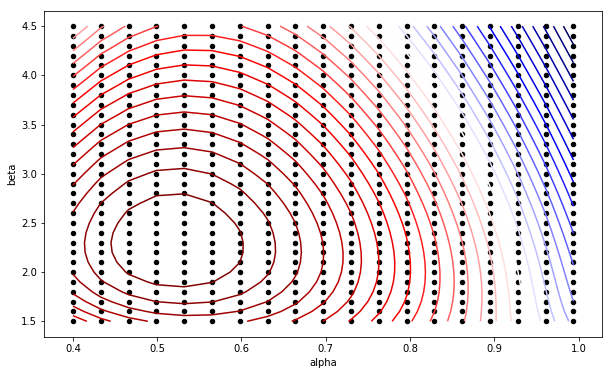

In [8]:
D_alpha = numpy.arange(0.4,1.0+1e-9,0.033 )
D_beta =  numpy.arange(1.5,4.5+1e-9,0.1 )
X,Y = numpy.meshgrid(D_alpha,D_beta)

#G = numpy.array(list(zip(X.flatten(),Y.flatten())))
D = numpy.array(D)
Alpha =  X.flatten()
Alpha = Alpha[:,numpy.newaxis]
A = numpy.repeat(Alpha,D.shape[0],axis=1)
A *= -1
A *= D
A = numpy.exp(A)
A = Alpha * A

Beta = Y.flatten()
Beta = Beta[:,numpy.newaxis]
B = numpy.repeat(Beta,D.shape[0],axis=1)
B *= -1
B *= D
B = numpy.exp(B)
B = Beta * B

L_A_B = numpy.log(A + B) - numpy.log(2)
L_A_B = numpy.sum(L_A_B,axis=1) 
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.scatter(X,Y,s=20,alpha=1,c='k')
levels = numpy.arange(numpy.min(L_A_B),numpy.max(L_A_B),1.0)
ax.contour(X,Y,numpy.reshape(L_A_B,X.shape),levels, cmap="seismic")
###

### Gradent-Based Optimization (10 P)

As an alternative to computing the log-likelihood for a whole grid, we would like to find the optimal parameters $\alpha,\beta$ by gradient-based optimization. The partial derivatives of the log-likelihood function are given by:

\begin{align*}
\frac{\partial \ell(\alpha,\beta)}{\partial \alpha} &= \sum_{i=1}^N \frac{e^{-\alpha x_i} (1 - \alpha x_i)}{\alpha e^{-\alpha x_i} + \beta e^{-\beta x_i}}\\
\frac{\partial \ell(\alpha,\beta)}{\partial \beta} &= \sum_{i=1}^N \frac{e^{-\beta x_i} (1 - \beta x_i)}{\alpha e^{-\alpha x_i} + \beta e^{-\beta x_i}}
\end{align*}

A gradient ascent step of the log-likelihood function takes the form

$$
\begin{pmatrix}
\alpha\\
\beta
\end{pmatrix} \leftarrow
\begin{pmatrix}
\alpha\\
\beta
\end{pmatrix} + \gamma \nabla_{\alpha,\beta} \ell(\alpha,\beta)
$$

where $\gamma$ is a learning rate to be defined. We start with initial parameters $\alpha=0.7$ and $\beta=3.0$.


* **Implement the gradient ascent procedure.**
* **Run the gradient ascent with parameter $\gamma = 0.005$.**
* **Plot the trajectory of the gradient ascent in superposition to the contour plot of the previous exercise.**

[0.7, 0.4829964866651601, 0.55082896512327639, 0.50883684777177463, 0.53117817789923494, 0.51772257972894775, 0.52492306497142338, 0.52047201283012512, 0.5226725315621078, 0.52113440253521515, 0.52172224757247698, 0.52113015468811541, 0.52121378273117569, 0.52093354811803794, 0.52086928718042258, 0.52069787344469931, 0.52059816298489814, 0.52047078430331029, 0.52037011100912367, 0.52026580683446366, 0.52017406865702964]
[3.0, 2.9805615201389144, 2.9589992749395191, 2.9392299203158725, 2.9191320938833538, 2.8998710140478061, 2.8807932768046509, 2.8622601491730242, 2.8440704513774171, 2.8263337669653787, 2.8089880291311951, 2.7920647638978395, 2.7755437672264209, 2.7594323979272382, 2.7437225046163145, 2.7284137528865124, 2.7135010736400624, 2.6989814211157461, 2.684850183952038, 2.6711031191461609, 2.6577353519680011]


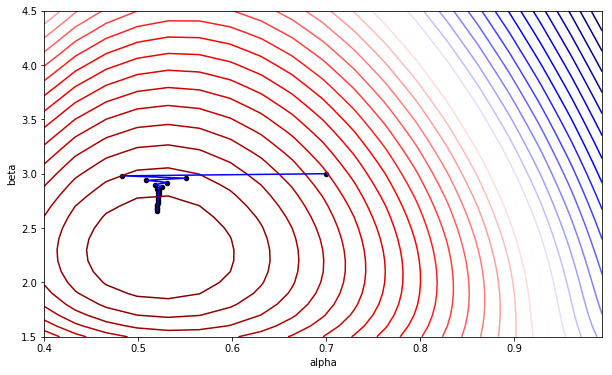

In [24]:
def evaluate_gradient( value_alpha , value_beta ):
    alpha_reuse = ( value_alpha * -1 ) * D
    beta_reuse = ( value_beta * -1 ) * D
    common_denominator = ( value_alpha * numpy.exp( alpha_reuse ) ) + ( value_beta * numpy.exp( beta_reuse ) )
    alp = numpy.sum(( numpy.exp( alpha_reuse ) * ( 1 + alpha_reuse ) ) / common_denominator)
    bet = numpy.sum(( numpy.exp( beta_reuse ) * ( 1 + beta_reuse ) ) / common_denominator)
    return alp , bet

value_alpha = 0.7
value_beta = 3.0
learning_rate = 0.005
iterations = 20
a_points = []
a_points.append(value_alpha)
b_points = []
b_points.append(value_beta)

for i in range( iterations ):
    a_mov, b_mov = evaluate_gradient( value_alpha , value_beta )
    value_alpha += learning_rate * a_mov
    value_beta += learning_rate * b_mov
    a_points.append(value_alpha)
    b_points.append(value_beta)

print a_points
print b_points    
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.plot(a_points, b_points,c='b')
ax.scatter(a_points, b_points,s=20,alpha=1,c='k')
levels = numpy.arange(numpy.min(L_A_B),numpy.max(L_A_B),1.0)
ax.contour(X,Y,numpy.reshape(L_A_B,X.shape),levels, cmap="seismic")


As it can be seen, the optimization procedure does not converge in reasonable time and seems to oscillate.

* **Explain the problem(s) with this approach. Propose a simple improvement of the optimization technique and apply it.**

The main problem with this approach is that it learns to much from each step so that is way is oscillating that much. A good idea would be to focus on the evolution of the serie as we are producing the new alphas and betas so we would realize the final direction that it follows and it will get faster to the solution

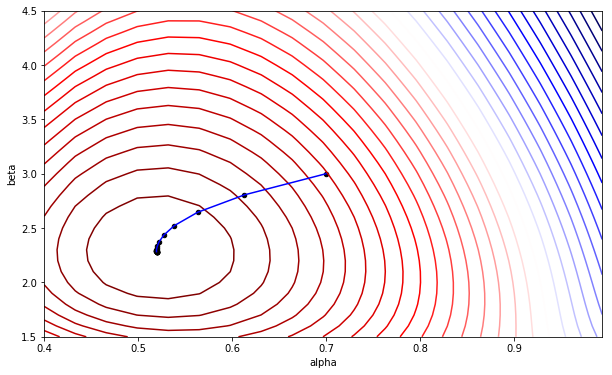

In [39]:
value_alpha = 0.7
value_beta = 3.0
learning_rate_a = 0.002
learning_rate_b = 0.05
iterations = 20
a_points = []
a_points.append(value_alpha)
b_points = []
b_points.append(value_beta)

for i in range( iterations ):
    a_mov, b_mov = evaluate_gradient( value_alpha , value_beta )
    value_alpha += learning_rate_a * a_mov
    value_beta += learning_rate_b * b_mov
    a_points.append(value_alpha)
    b_points.append(value_beta)

   
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.plot(a_points, b_points,c='b')
ax.scatter(a_points, b_points,s=20,alpha=1,c='k')
levels = numpy.arange(numpy.min(L_A_B),numpy.max(L_A_B),1.0)
ax.contour(X,Y,numpy.reshape(L_A_B,X.shape),levels, cmap="seismic")